# **CNN for Subset of Places365-Standard**

### **What is CNN**
Convolutional Neural Network (CNN) is a type of deep learning model, especially effective for processing grid-like data, such as images.

### **CNN Applications**
1. Image classification
2. Object detection
3. Facial recognition
4. Medical imaging
5. Video analysis

### **Places365-Standard**
Places365-Standard is a large-scale image dataset designed for scene recognition. It’s widely used to train and evaluate convolutional neural Networks. Networks (CNNs) on tasks like indoor/outdoor classification, scene categorization, and context-based recognition. Which makes it a good challenge to take in building a number of CNNs.

### **The Goal**
The target here is to build a CNN that can classify an indoor scene from 5 clasees from the Places365-Standard becuase due to the inability to use the whole dataset. **The classes are:** Hotel room, Library indoor, Art Gallery, Banquet Hall, and Supermarket. Also, this is a redo of the former CNN model my colleagues and I did in 2024. You can find the previous model on: https://github.com/mvincentbb/CEREBRO_AI_PROJECT \
I took the same dataset provided in my previous work and tried to keep the changes to a minimum, as I wanted to make it a fair comparison between this CNN and the previous one. All changes made are to make the model perform better.
## **Import Libraries and Functions**

In [ ]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pandas.core.common import flatten
import random
from random import choice, shuffle
from shutil import move
import torch
from torch import nn
from torch import optim
from torchsummary import summary
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## **Directory and Unziping the Dataset File**
Make a directory for the dataset and then load the files in it.

In [ ]:
!mkdir Places365  # Create a new directory
!unzip ./Places365.zip -d Places365

Streaming output truncated to the last 5000 lines.
  inflating: Places365/data_256/library indoor/00000428.jpg  
  inflating: Places365/data_256/library indoor/00000400.jpg  
  inflating: Places365/data_256/library indoor/00000366.jpg  
  inflating: Places365/data_256/library indoor/00000372.jpg  
  inflating: Places365/data_256/library indoor/00000414.jpg  
  inflating: Places365/data_256/library indoor/00000399.jpg  
  inflating: Places365/data_256/library indoor/00000158.jpg  
  inflating: Places365/data_256/library indoor/00000164.jpg  
  inflating: Places365/data_256/library indoor/00000602.jpg  
  inflating: Places365/data_256/library indoor/00000616.jpg  
  inflating: Places365/data_256/library indoor/00000170.jpg  
  inflating: Places365/data_256/library indoor/00000825.jpg  
  inflating: Places365/data_256/library indoor/00000831.jpg  
  inflating: Places365/data_256/library indoor/00000819.jpg  
  inflating: Places365/data_256/library indoor/00000992.jpg  
  inflating: Places

## **Images Count checking**
The file has 5000 images, 1000 for each class.

In [ ]:
data_dir = pathlib.Path('./Places365/data_256')
dir = os.listdir(data_dir)
# List to store all empty directories
empty = []

# Traversing through the set
for root, dirs, files in os.walk(data_dir):
    # Checking the size of a tuple
    if not len(dirs) and not len(files):
        # Adding the empty directory to the list
        empty.append(root)
# Now, to see if we have an empty directory
print("Empty Directories:", empty)

# If there are no empty directories, this means I can see the total number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print("The total number of images is: ", image_count)

Empty Directories: []
The total number of images is:  5000


## **Display A Sample Of Images**
This a mere try to show out the data sample.

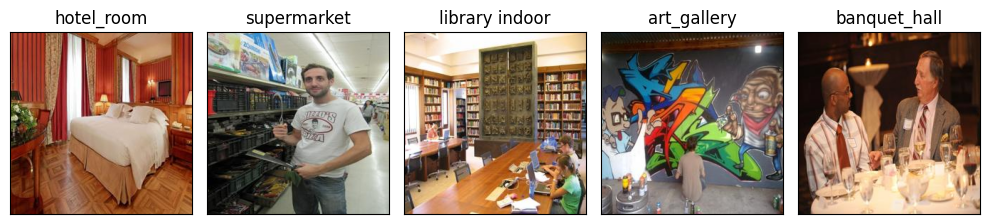

In [ ]:
# Place the data folder path
data_dir = './Places365/data_256'

# Define the number of images to display (one per class)
num_images = len([os.path.join(data_dir, d) for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

# Adjust figure size for a single row (the width can be modified as needed)
plt.figure(figsize=(num_images * 2, 3))

# Loop through each class directory
for i, class_dir in enumerate(os.listdir(data_dir)):
    if os.path.isdir(os.path.join(data_dir, class_dir)):  # Check if it's a directory
        class_name = class_dir  # Extract class name from directory name

        # Get all image paths within the class directory
        image_paths = [os.path.join(data_dir, class_dir, filename) for filename in os.listdir(os.path.join(data_dir, class_dir))
                       if os.path.isfile(os.path.join(data_dir, class_dir, filename))]

        # Choose a random image from the class (modify if you want the first image)
        random_image_path = choice(image_paths)

        # Load the image
        image = plt.imread(random_image_path)

        # Display the image on a subplot
        plt.subplot(1, num_images, i + 1)  # Arrange images in one row
        plt.imshow(image)
        plt.title(class_name)
        plt.xticks([])
        plt.yticks([])

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

## **Check the Images Dimensions**
Next, I am expecting to work with 256x256 images, so I made a little checking loop

In [ ]:
print(f"--- Checking image dimensions ---")
expected_size=(256, 256) # Define the target size for images
matching_images = []
mismatch_images = []
# User specified all photos are JPG
image_extensions = ('.jpg', '.jpeg') # Only checking for JPG/JPEG extensions

# Walk through the directory and its subdirectories
for root, _, files in os.walk(data_dir):
    for file in files:
        # Check if the file is a JPG/JPEG image type
        if file.lower().endswith(image_extensions):
            file_path = os.path.join(root, file)
            try:
                # Open the image using Pillow (PIL)
                with Image.open(file_path) as img:
                    # Compare the image's actual size with the expected size
                    if img.size == expected_size:
                        matching_images.append(file_path)
                    else:
                        mismatch_images.append(file_path)
                        print(f"  Mismatch: {file_path} has dimensions {img.size}, expected {expected_size}")
            except Exception as e:
                # Handle cases where the file might be corrupted or not a valid image
                print(f"  Error opening image {file_path}: {e}")
                mismatch_images.append(file_path) # Consider unreadable files as mismatches for this check

print(f"Number of images matching {expected_size[0]}x{expected_size[1]}: {len(matching_images)}")
print(f"Number of images NOT matching {expected_size[0]}x{expected_size[1]}: {len(mismatch_images)}")

--- Checking image dimensions ---
Number of images matching 256x256: 5000
Number of images NOT matching 256x256: 0


## Test, Train, and Validation Sets
First, we need to create three folders: one for training, one for validation, and one for testing.

In [ ]:
# Define your dataset path
dataset = ImageFolder(data_dir)


# Define the size of the dataset and the split
dataset_size = len(dataset)
train_size = int(0.64 * dataset_size)  # 64% for training
validation_size=int(0.16 * dataset_size)  # 16% for validation
test_size = dataset_size - train_size - validation_size  # 20% for testing

# Split the dataset into training and test sets
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

## **Prepare the Data**
Now, after I split the data into the desired split, I have to transform it using transforms and call the data loaders for my dataset.\
Here I sat up a different kind of transforms which proved useful as it fit the model architecture and helped raise its performance.


In [ ]:
# Define data augmentation and preprocessing transformations for the training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # encourages spatial robustness
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define transformations for the validation and test data
rest_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Define the size of the batches
batch_size=32
# Set the transformations for the subsets
train_dataset.dataset.transform = train_transforms
validation_dataset.dataset.transform = rest_transforms
test_dataset.dataset.transform = rest_transforms

# Create DataLoaders for the training and test sets
# The training set should be shuffled at every epoch, pinned Memory to optimize data transfer between CPU and GPU
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True) # do not shuffle validation and test

#verify lengths
print(f"Length of daraset :         {dataset_size}")
print(f"Length of Train Data :      {len(train_dataset)}")
print(f"Length of Validation Data : {len(validation_dataset)}")
print(f"Length of Test Data :       {len(test_dataset)}")

Length of daraset :         5000
Length of Train Data :      3200
Length of Validation Data : 800
Length of Test Data :       1000


## **CNN Architecture**
After defining our transformers and dataloader, now it is time to build the CNN architecture. I used this type of building architecture (which is different from the previous one) because it showed a representation and better readability for the CNN.

In [ ]:
class Places365CNN(nn.Module):
    def __init__(self, num_classes=5): # num_classes as an argument for flexibility
        super().__init__()

        # Convolutional layers with batch normalization and dropout
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.4),
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01),
            # Adaptive pooling to ensure output size is (1, 1)
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Fully Connected layers
        self.FC = nn.Sequential(
            nn.Linear(512, 512),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes) # We have 5 classes
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        # Flatten before fully connected layers
        out = torch.flatten(out, 1)
        out = self.FC(out)

        # Return the final output
        return out

## **Hyperparameters Initialization**
This block contains the following:  
1. Making an instance of our model.     
2. Choosing Cross-Entropy Loss as the loss function.    
3. Choosing ADAM as the optimization algorithm.   
4. Using a learning rate scheduler that reduces the learning rate when a specified metric stops improving. My choice was validation accuracy.
5. Number of epochs.
6. Setting the device for the processing (GPU or CPU)

In [ ]:
model = Places365CNN()
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)
n_epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model Parameters and GPU Check
The following block is simply to see whether CUDA is available to use the GPU, and see the trainable parameters of the model.

In [ ]:
print("----------------------------- GPU Availability -----------------------------")
print("Is the GPU Available? ", torch.cuda.is_available())
print("----------------------------- The Model Summary -----------------------------")
# Move the model to the device before calling summary
model.to(device)
summary(model, (3, 256, 256))

----------------------------- GPU Availability -----------------------------
Is the GPU Available?  True
----------------------------- The Model Summary -----------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
         LeakyReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
         LeakyReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
        LeakyReLU-11          [-1, 128, 64, 64] 

## **Train the model**
There are several differences between this training loop and the earlier version (check the mentioned repo at the top). This training loop has:
1. Early stopping
2. Correct way to calculate the loss and accuracy.
3. Using the learning rate scheduler.
4. Saving the best trained model.
5. The option to use the validation set.

In [ ]:
def train(model, optimizer, trainloader, valloader, loss_fn, scheduler, n_epochs, device):
    train_history = [] # To capture the history of the training set
    val_history = [] # To capture the history of the validation set
    # Move the model to the chosen device
    model.to(device)
    # Early stopping variables
    best_val_acc = 0
    early_stop_counter = 0
    PATIENCE = 7  # Number of epochs with no improvement before stopping
    # Loop through epochs
    for epoch in range(n_epochs):
        # Set the model to train mode
        model.train()
        train_loss = 0.0
        train_correct_predictions = 0
        train_total_samples = 0
        # Training loop
        for images, labels in trainloader:
            # Move data to the device (CPU or GPU)
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            output = model(images)
            # Calculate loss
            loss = loss_fn(output, labels)
            # Backward pass and parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0) # Accumulate weighted loss
            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1) # Get the class with the highest probability
            train_total_samples += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = train_loss / train_total_samples
        epoch_train_accuracy = train_correct_predictions / train_total_samples
        train_history.append({'loss': epoch_train_loss, 'accuracy': epoch_train_accuracy})

        # Validation loop after each training epoch
        if valloader:
            # Set the model to eval mode
            model.eval()
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0
            with torch.no_grad():  # Deactivate gradient calculation for validation
                for val_inputs, val_labels in valloader:
                    # Move data to the chosen device
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    val_y_pred = model(val_inputs)
                    validation_loss = loss_fn(val_y_pred, val_labels)
                    val_loss += validation_loss.item() * val_inputs.size(0) # Accumulate weighted loss

                    # Calculate validation accuracy
                    _, predicted = torch.max(val_y_pred.data, 1)
                    val_total_samples += val_labels.size(0)
                    val_correct_predictions += (predicted == val_labels).sum().item()

            # Calculate average validation loss and accuracy for the epoch
            epoch_val_loss = val_loss / val_total_samples
            epoch_val_accuracy = val_correct_predictions / val_total_samples
            val_history.append({'loss': epoch_val_loss, 'accuracy': epoch_val_accuracy})

            # Learning rate scheduling step
            scheduler.step(epoch_val_loss)

            # Early stopping check
            if epoch_val_accuracy > best_val_acc:
                best_val_acc = epoch_val_accuracy
                early_stop_counter = 0
                torch.save(model.state_dict(), "best_model.pth")
            else:
                early_stop_counter += 1
                if early_stop_counter >= PATIENCE:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break

        # Print epoch information and append losses for visualization
        # Print epoch information
        print(f"Epoch: {epoch+1}/{n_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy:.4f}")

    return train_history, val_history

## **Initiate the Training Process**
Now, I have built the training function. I will start the model training and plot the training vs validation curves  

In [ ]:
train_history, val_history = train(model, optimizer, trainloader, valloader, loss_fn, scheduler, n_epochs, device)

Epoch: 1/50 | Train Loss: 1.4279 | Train Acc: 0.3856 | Val Loss: 1.3287 | Val Acc: 0.4763
Epoch: 2/50 | Train Loss: 1.3240 | Train Acc: 0.4706 | Val Loss: 1.3011 | Val Acc: 0.4800
Epoch: 3/50 | Train Loss: 1.2751 | Train Acc: 0.5050 | Val Loss: 1.2769 | Val Acc: 0.5200
Epoch: 4/50 | Train Loss: 1.2322 | Train Acc: 0.5403 | Val Loss: 1.2383 | Val Acc: 0.5125
Epoch: 5/50 | Train Loss: 1.1950 | Train Acc: 0.5803 | Val Loss: 1.5185 | Val Acc: 0.4012
Epoch: 6/50 | Train Loss: 1.1654 | Train Acc: 0.5966 | Val Loss: 1.2091 | Val Acc: 0.5425
Epoch: 7/50 | Train Loss: 1.1095 | Train Acc: 0.6419 | Val Loss: 1.1355 | Val Acc: 0.6075
Epoch: 8/50 | Train Loss: 1.0696 | Train Acc: 0.6663 | Val Loss: 1.1955 | Val Acc: 0.6038
Epoch: 9/50 | Train Loss: 1.0463 | Train Acc: 0.6897 | Val Loss: 1.1972 | Val Acc: 0.6075
Epoch: 10/50 | Train Loss: 0.9513 | Train Acc: 0.7497 | Val Loss: 1.0528 | Val Acc: 0.6613
Epoch: 11/50 | Train Loss: 0.9177 | Train Acc: 0.7628 | Val Loss: 0.9655 | Val Acc: 0.7163
Epoch: 1

## **Plots**
Here, I shall present both the losses, and the accuracy during the training process.

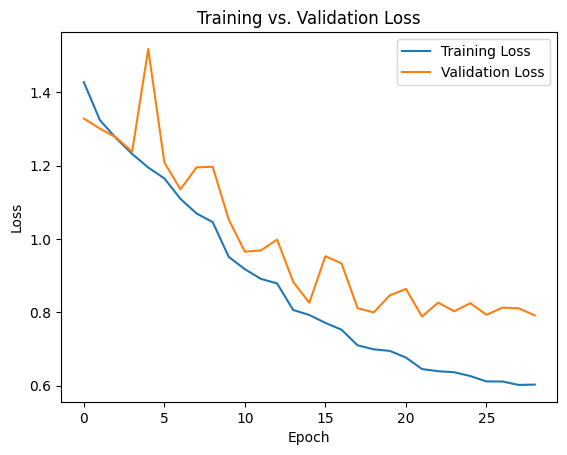

In [ ]:
train_losses = [d['loss'] for d in train_history]
val_losses = [d['loss'] for d in val_history]
# Plot training and validation loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

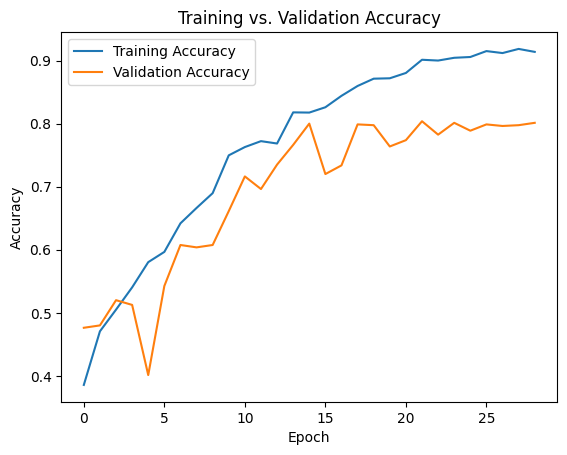

In [ ]:
train_accuracy = [d['accuracy'] for d in train_history]
val_accuracy = [d['accuracy'] for d in val_history]
# Plot training and validation loss curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

## Evaluate the Model
Now, to evaluate the model I have built a testing function.

In [ ]:
def test(model, testloader, loss_fn):
    all_predictions = []
    all_targets = []
    total_loss = 0
    # Use best trained model
    model.load_state_dict(torch.load("best_model.pth"))
    # Set the model to eval mode
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency during testing
        for images, labels in testloader:
            # Move data to device (CPU or GPU)
            images, labels = images.to(device), labels.to(device)

            # Forward pass through the model
            outputs = model(images)
            # Calculate loss
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * images.size(0) # Accumulate weighted loss
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class index

            # Store predictions and targets
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    return all_targets, all_predictions

Now, to get all the statistics regarding the model.

------------------------------ Metrics ---------------------------------------
Accuracy: 83.10%
F1-score: 83.07%
Precision: 83.21%
Recall: 83.10%
------------------------------ Confusion Matrix ---------------------------------------


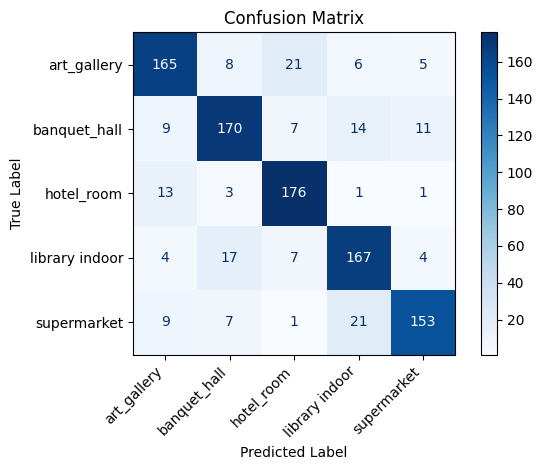

In [ ]:
all_targets, all_predictions = test(model, testloader, loss_fn)
accuracy = accuracy_score(all_targets, all_predictions)
print("------------------------------ Metrics ---------------------------------------")
print(f"Accuracy: {accuracy:.2%}")
precision = precision_score(all_targets, all_predictions, average='weighted')  # Adjust average as needed
recall = recall_score(all_targets, all_predictions, average='weighted')  # Adjust average as needed
f1 = f1_score(all_targets, all_predictions, average='weighted')  # Adjust average as needed

print(f"F1-score: {f1:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")

print("------------------------------ Confusion Matrix ---------------------------------------")
# Convert lists into np arrays
all_targets_arr = np.array(all_targets)
all_predictions_arr = np.array(all_predictions)

cm = confusion_matrix(all_targets_arr, all_predictions_arr)
# plot the confusion matrix
cm_dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
cm_dis.plot(cmap=plt.cm.Blues) # Plot it

# Now, access the axes object from the cm_display object
ax = cm_dis.ax_

# Rotate the x-axis tick labels
ax.set_xticklabels(dataset.classes, rotation=45, ha='right') # 'ha' means horizontal alignment

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## **Conclusion**
Although there is an overfitting as shown, it is not severe, which shows the countermeasures are working, and also saving the best trained model is an advantage, where it can be used later on (e.g., train it more).\
The saved model has shown better results with an increase in accuracy by ~8% than the earliest implementation, which shows a hope for future work where it can even surpass the current one.